In [134]:
import numpy as n
from matplotlib import pyplot as plt
import os
import numpy.lib.recfunctions as rfn
import copy

from sklearn.metrics import confusion_matrix

import torch
from torch import nn

In [3]:
def dot(a, b):
    return n.sum(a * b, axis=-1)

def mag(a):
    return n.sqrt(n.sum(a*a, axis=-1))

def get_angle(a, b):
    cosab = dot(a, b) / (mag(a) * mag(b)) # cosine of angle between vectors
    angle = n.arccos(cosab) # what you currently have (absolute angle)

    b_t = b[:,[1,0]] * [1, -1] # perpendicular of b

    is_cc = dot(a, b_t) < 0

    # invert the angles for counter-clockwise rotations
    angle[is_cc] = 2*n.pi - angle[is_cc]
    return 360 - n.rad2deg(angle)

### Load data files
`data_root` should contain the root directory of the folder downloaded from Dropbox.

In [9]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data

In [10]:
data_root = '/mnt/d/Ali/Google Drive/SWC/Experimental Neuroscience/social and affective systems/rat_social_beh'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'


In [194]:
all_data = load_data(data_root, dlc_dir, ann_dir)

## Velocities

In [195]:
def calculate_velocity(trial):
    names = []; dtypes = []; datas = []
    velocities_calculated = []
    for label in trial.dtype.names:
        if label[-2:] in ['_x', '_y']:
            names.append(label+'_vel')  
            dtypes += [n.float]
            datas += [n.zeros(trial.shape[0])]
            velocities_calculated.append(label)
    trial = rfn.append_fields(trial, names, datas, dtypes)
    trial = n.array(trial, trial.dtype)
    for label in velocities_calculated:
        vel = n.gradient(trial[label])
        trial[label + '_vel'] = vel
    return trial
def normalize_trial(trial, feature_labels, nan = -10000):
    ref_x = trial[feature_labels[1]].copy()
    ref_y = trial[feature_labels[0]].copy()
    for i,label in enumerate(feature_labels):
        if label[-1] == 'y':
    #         print('y-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_y
    #         print('y-post:', n.nanmax(features[:,i]))
        elif label[-1] == 'x':
    #         print('x-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_x
    #         print('x-post:', n.nanmax(features[:,i]))

    mouse_1_pos_labels = []
    mouse_2_pos_labels = []
    mouse_1_vel_labels = []
    mouse_2_vel_labels = []
    for label in feature_labels:
        if label[-3:] == 'vel':
            if label[-7] == '1':
                mouse_1_vel_labels.append(label)
            else:
                mouse_2_vel_labels.append(label)
        else:
            if label[-3] == '1':
                mouse_1_pos_labels.append(label)
            else:
                mouse_2_pos_labels.append(label)


    mouse_1_pos = n.zeros((len(mouse_1_pos_labels),len(trial)))
    for i,l in enumerate(mouse_1_pos_labels): mouse_1_pos[i]=trial[l]
    mouse_2_pos = n.zeros((len(mouse_2_pos_labels),len(trial)))
    for i,l in enumerate(mouse_2_pos_labels): mouse_2_pos[i]=trial[l]
    mouse_1_vel = n.zeros((len(mouse_1_vel_labels),len(trial)))
    for i,l in enumerate(mouse_1_vel_labels): mouse_1_vel[i]=trial[l]
    mouse_2_vel = n.zeros((len(mouse_2_vel_labels),len(trial)))
    for i,l in enumerate(mouse_2_vel_labels): mouse_2_vel[i]=trial[l]
    # TODO how to normalize??
    trial_data = n.concatenate([mouse_1_pos, mouse_2_pos, mouse_1_vel, mouse_2_vel])
    if nan is not None:
        trial_data = n.nan_to_num(trial_data, nan=nan)
    
    trial_labels = n.concatenate([mouse_1_pos_labels, mouse_2_pos_labels, mouse_1_vel_labels, mouse_2_vel_labels])
    
    return trial_data, trial_labels

In [196]:
trial_keys = list(all_data.keys())

for key in all_data.keys():
    all_data[key] = calculate_velocity(all_data[key])

datas = []
for key in trial_keys:
    datas.append(normalize_trial(all_data[key], feature_labels)[0])

features_all = n.concatenate(datas, axis=1).T

targets_all = n.concatenate([all_data[key]['ann'] for key in trial_keys]).T

## Separate train, test and val sets

In [213]:
def split_sets(features_all,targets_all, chunk_size=500, splits= (0.7, 0.2, 0.1)):
    data_len = features_all.shape[0]
    num_chunks = data_len // chunk_size
    chunk_list = n.random.choice(range(num_chunks), size=num_chunks, replace=False)

    test_chunk_idx_bound = splits[0]*num_chunks
    val_chunk_idx_bound = (splits[0]+splits[1])*num_chunks

    features_train = []
    features_test = []
    features_val = []
    targets_train = []
    targets_test = []
    targets_val = []

    for i in range(num_chunks):
        curr_chunk_idx = chunk_list[i]*chunk_size
        curr_chunk = features_all[curr_chunk_idx:curr_chunk_idx+chunk_size,:]
        curr_chunk_t = targets_all[curr_chunk_idx:curr_chunk_idx+chunk_size]
        if i < test_chunk_idx_bound:
            features_train.append(curr_chunk)
            targets_train.append(curr_chunk_t)
        elif i < val_chunk_idx_bound:
            features_test.append(curr_chunk)
            targets_test.append(curr_chunk_t)
        else:
            features_val.append(curr_chunk)
            targets_val.append(curr_chunk_t)

    features_train = n.concatenate(features_train, axis=0)
    features_test = n.concatenate(features_test, axis=0)
    features_val = n.concatenate(features_val, axis=0)
    
    targets_val = n.concatenate(targets_val)
    targets_test = n.concatenate(targets_test)
    targets_train = n.concatenate(targets_train)
    
    return features_train, features_test, features_val, targets_train, targets_test, targets_val

def str_to_int(targets, mapping = None):
    categories = n.unique(targets)
    N_categories = len(categories)
    if mapping is None:
        mapping = {}
        i = 0
        for c in categories:
            mapping[c] = i
            i += 1
    targets_int = n.array([mapping[s] for s in targets], dtype=int)
    
    return targets_int, mapping
    

In [214]:
targets_int, target_map = str_to_int(targets_all)
categories = target_map.keys()
N_categories = len(categories)

In [215]:
features_all.shape

(210617, 80)

In [216]:
ft_tr, ft_ts, ft_vl, tg_tr, tg_ts, tg_vl = split_sets(features_all, targets_int)

In [225]:
ft_tr = torch.tensor(ft_tr).float()
ft_ts = torch.tensor(ft_ts).float()
tg_tr = torch.tensor(tg_tr).long()
tg_ts = torch.tensor(tg_ts).long()

/home/ali/anaconda3/envs/gp/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/ali/anaconda3/envs/gp/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/ali/anaconda3/envs/gp/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/ali/anaconda3/envs/gp/lib/python3.6/site-packages/ipykernel/__mai

In [226]:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N_batch = 16
D_in = ft_tr.shape[1] 
D_out = N_categories
hidden_dims = [300,300,300]


layers = []
prev_dim = D_in
for dim in hidden_dims:
    layers += [torch.nn.Linear(prev_dim, dim),
               torch.nn.ReLU()]
    prev_dim = dim
layers += [torch.nn.Linear(prev_dim, D_out)]

loss_fn = torch.nn.CrossEntropyLoss()

In [228]:
trackers = {'test_loss' : [], 't' : [], 'train_loss' : [], 'test_frac_correct': []}
best_model = None
def track():
    for key in trackers.keys():
        trackers[key].append(globals()[key])

model = nn.Sequential(*layers)
learning_rate = 1e-4
print_interval = 50


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
t = 0
end = False
for epoch_idx in range(10):
    print("### EPOCH {:2d} ###".format(epoch_idx))
    indices = n.random.choice(range(tg_tr.shape[0]), tg_tr.shape[0], False)
    num_batches = len(indices) // N_batch + 1
    for batch_idx in range(num_batches):
        batch_train_x = ft_tr[indices[batch_idx*N_batch :(batch_idx+1)*N_batch]]
        batch_train_y = tg_tr[indices[batch_idx*N_batch : (batch_idx+1)*N_batch]]
        # Forward pass: compute predicted y by passing x to the model.
        batch_train_y_pred = model(batch_train_x)

        # Compute and print loss.
        loss = loss_fn(batch_train_y_pred, batch_train_y)
        if batch_idx % print_interval == 0:
            prediction_test = model(ft_ts)
            train_loss = loss.item()
            test_loss= loss_fn(prediction_test, tg_ts).item()
            
            
            pred_labels = n.argmax(prediction_test.detach().numpy(),axis=1)
            true_labels = tg_ts.detach().numpy()
            correct_preds = n.array(pred_labels == true_labels, n.int)
            test_frac_correct = n.mean(correct_preds)
            
            if len(trackers['test_loss']) == 0 or test_loss < min(trackers['test_loss']):
                best_model = copy.deepcopy(model)
            print("Batch {:3d}, Train Loss: {:5f}, Test Loss: {:5f}, Test Correct Frac: {:.3f}".format(batch_idx, train_loss, test_loss, test_frac_correct))
            track()
#             if t > print_interval*3 and trackers['test_loss'][-2] < trackers['test_loss'][-1] and \
#                 trackers['test_loss'][-3] < trackers['test_loss'][-2]:
#                 print("End training")
#                 end = True
#                 break
        t += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if end: break

### EPOCH  0 ###
Batch   0, Train Loss: 256.322357, Test Loss: 197.455719, Test Correct Frac: 0.028
Batch  50, Train Loss: 0.007038, Test Loss: 0.818477, Test Correct Frac: 0.866
Batch 100, Train Loss: 0.257037, Test Loss: 0.717227, Test Correct Frac: 0.882
Batch 150, Train Loss: 0.490652, Test Loss: 0.683601, Test Correct Frac: 0.884
Batch 200, Train Loss: 0.176293, Test Loss: 0.668611, Test Correct Frac: 0.879
Batch 250, Train Loss: 0.016335, Test Loss: 1.880834, Test Correct Frac: 0.903
Batch 300, Train Loss: 0.120495, Test Loss: 1.604633, Test Correct Frac: 0.898
Batch 350, Train Loss: 0.104092, Test Loss: 1.580677, Test Correct Frac: 0.903
Batch 400, Train Loss: 0.173301, Test Loss: 1.573352, Test Correct Frac: 0.904
Batch 450, Train Loss: 0.900508, Test Loss: 1.047869, Test Correct Frac: 0.909
Batch 500, Train Loss: 0.053171, Test Loss: 0.898830, Test Correct Frac: 0.922
Batch 550, Train Loss: 0.277025, Test Loss: 0.922918, Test Correct Frac: 0.916
Batch 600, Train Loss: 0.516932

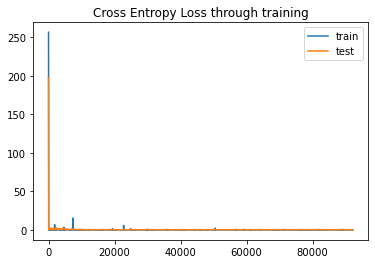

In [229]:
plt.plot(trackers['t'],trackers['train_loss'], label='train')
plt.plot(trackers['t'],trackers['test_loss'], label='test')
plt.title("Cross Entropy Loss through training")
plt.legend()

Text(0.5, 1.0, 'Fraction of correct labels on test set through training')

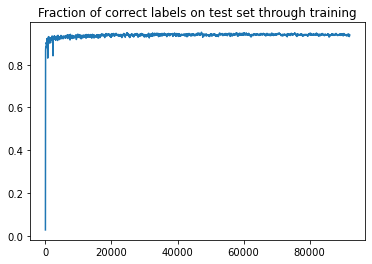

In [231]:
plt.plot(trackers['t'], trackers['test_frac_correct'])
plt.title("Fraction of correct labels on test set through training")

In [235]:
prediction_test = best_model(ft_ts)

pred = n.argmax(prediction_test.detach().numpy(),axis=1)

true = tg_ts.detach().numpy()

In [236]:
confmat = confusion_matrix(true, pred, normalize='true')

In [237]:
n.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [238]:
print(confmat)

[[0.361 0.128 0.049 0.000 0.019 0.023 0.000 0.421]
 [0.000 0.906 0.041 0.000 0.000 0.018 0.000 0.035]
 [0.000 0.001 0.843 0.048 0.004 0.061 0.000 0.042]
 [0.000 0.000 0.203 0.482 0.000 0.030 0.000 0.285]
 [0.056 0.000 0.497 0.056 0.299 0.000 0.000 0.091]
 [0.002 0.037 0.250 0.000 0.000 0.708 0.000 0.004]
 [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000]
 [0.005 0.004 0.032 0.014 0.001 0.007 0.005 0.933]]


In [239]:
categories

dict_keys(['Approach', 'Following', 'broadly-Social', 'conspecific-contact', 'head-to-head', 'head-to-tail', 'nan', 'no-contact'])

In [240]:
list(range(len(categories)))

[0, 1, 2, 3, 4, 5, 6, 7]

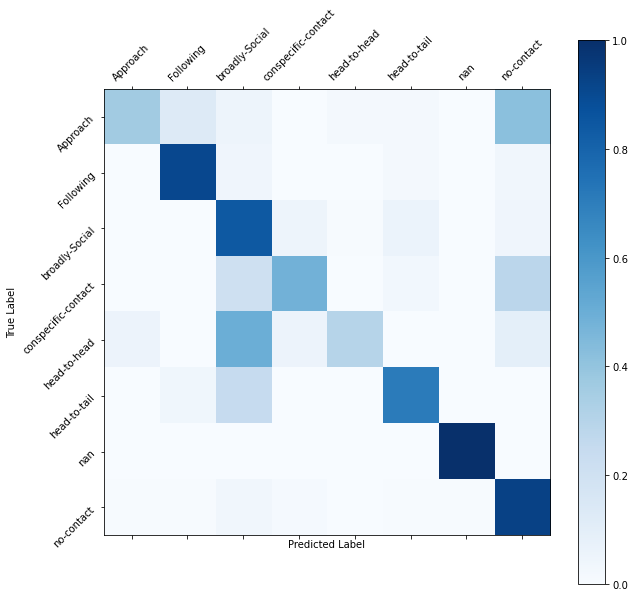

In [242]:
f, ax = plt.subplots(figsize=(10,10))
m = ax.matshow(confmat, cmap='Blues', vmin=0,  vmax=1)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(list(range(len(categories))))
ax.set_xticklabels(categories, rotation=45)
ax.set_yticks(list(range(len(categories))))
ax.set_yticklabels(categories, rotation=45)
f.colorbar(m)

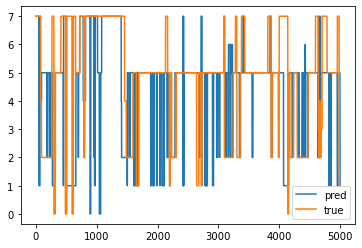

In [446]:
plt.plot(pred, label='pred')
plt.plot(true, label='true')
plt.legend()

Text(0.5, 1.0, 'Label is correct 0.62 of the time')

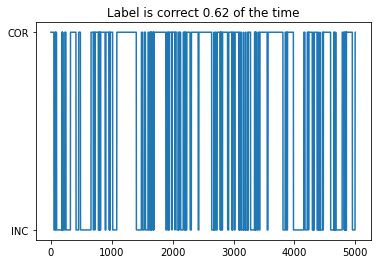

In [451]:
correct_preds = n.array(pred == true, dtype=int)
plt.plot(correct_preds)
plt.yticks([0,1], ['INC', 'COR'])
plt.title("Label is correct {:.2f} of the time".format(n.mean(correct_preds)))

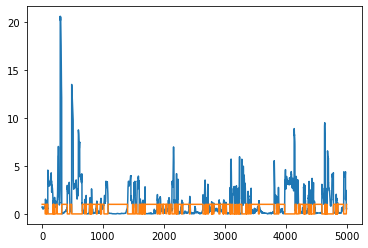

In [448]:

plt.plot([loss_fn(prediction_test[i:i+1],targets_test[i:i+1]).item() for i in range(len(pred))])
